# Analyzing the Influenza data via ARIMA for short term projections

In [20]:
from IPython.display import Javascript

### Mount data location

In [21]:
import os

os.chdir('.') ## for local

### Install python and R packages (installing R packages can be slow)

In [22]:
#%%capture
%reload_ext rpy2.ipython

%R needed.packages <- c('easypackages','tidyverse','lubridate','cowplot','colorspace','MLmetrics','imputeTS', 'broom', 'janitor', 'magrittr', 'kableExtra')
%R new.packages <- needed.packages[!(needed.packages %in% installed.packages()[,"Package"])]
%R if(length(new.packages)) install.packages(new.packages)

%R suppressPackageStartupMessages(library(easypackages))
%R suppressPackageStartupMessages(libraries(needed.packages))

R[write to console]: All packages loaded successfully



In [23]:
#%%capture
import time

## Data manipulation tools
import numpy as np
import pandas as pd
import pmdarima

## Time series analysis libraries sktime
from sktime.forecasting.compose            import ForecastingPipeline, TransformedTargetForecaster
from sktime.forecasting.compose            import AutoEnsembleForecaster
from sktime.transformations.compose        import TransformerPipeline
from sktime.transformations.series.compose import OptionalPassthrough
from sktime.forecasting.compose            import make_reduction
from sktime.forecasting.base               import ForecastingHorizon
from sktime.transformations.series.adapt   import TabularToSeriesAdaptor
from sktime.transformations.series.impute  import Imputer

from sktime.forecasting.model_selection    import ExpandingWindowSplitter
from sktime.forecasting.model_selection    import ForecastingGridSearchCV
from sktime.forecasting.model_selection    import temporal_train_test_split

from sklearn.preprocessing                 import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer
from sklearn.neighbors                     import KNeighborsRegressor
from sklearn.linear_model                  import ElasticNet

from sktime.forecasting.naive              import NaiveForecaster
from sktime.forecasting.ets                import AutoETS
from sktime.forecasting.arima              import AutoARIMA

## accessories
import pickle
import rpy2.robjects as ro

### R Functions

In [24]:
%%R

cols <- c("#396AB1", "#DA7C30", '#3E9651', '#CC2529')

plot_basic_timeseries <- function(ldf) {
  ggplot(ldf %>% pivot_longer(!date, names_to = 'region', values_to = 'incidence'), 
         aes(x = date, 
             y = incidence)) +
  geom_point(color = '#000000',
             fill = '#AAAAAA',
             shape = 21,
             size = 3) +
  geom_line(size = 1.05,
            alpha = 0.5) +
  facet_wrap(~region, ncol = 3, scales = 'free_y') +
  xlab('date') +
  ylab('Flu incidence') +
  theme_bw(24)
}

### Python Functions

In [25]:
def generate_predictions_for_region(lgs, ldata, lseries, lnt, n_ahead):
  lpred = []
  lreal = []
  lnaive = []
  lmodels = []
  fh = np.array([n_ahead])

  print(lseries)

  ltrain, ltest = make_data(ldata, lnt)

  lfit = lgs.fit(ltrain[[lseries]].dropna(), fh = fh)
  lmodels.append(lfit)

  print(lfit)

  for i in range(len(ldata[[lseries]]) - lnt):
    ltrain, ltest = make_data(ldata, lnt + i)
    lfit = lfit.fit(ltrain[[lseries]].dropna(), fh = fh)
    lpred.append(np.array(lfit.predict(fh)).flatten()[0])
    lnaive.append(ltrain[[lseries]].dropna().values.flatten()[-1])

    if len(ltest[[lseries]].values.flatten()) >= n_ahead:
      lreal.append(ltest[[lseries]].values.flatten()[n_ahead - 1])
    else:
      lreal.append(np.NAN)

  lfit = lfit.fit(make_data(ldata, len(ldata[[lseries]].dropna()))[[lseries]], fh = fh)
  lpred.append(np.array(lfit.predict(fh)).flatten()[0])
  lreal.append(np.NAN)
  lnaive.append(make_data(ldata, len(ldata[[lseries]]))[[lseries]].values.flatten()[-1])

  return lpred, lreal, lnaive, lmodels

def generate_predictions_for_country(lgscv, ldata, lnt, n_ahead):
  fdf = pd.DataFrame()

  for tseries in ldata.columns[1:]:
    l_pred, l_real, l_naive, lmodels = generate_predictions_for_region(lgscv, ldata, tseries, lnt, n_ahead)
    
    l_dates = [(pd.to_datetime(ldata.date.values[-1]) + pd.DateOffset(weeks = i + 1)).strftime('%Y-%m-%d') for i in range(n_ahead)]
    lpred_df = pd.DataFrame({'date': np.append(ldata.iloc[(lnt + n_ahead - 1):,].date.values, l_dates),
                             'Model': l_pred,
                             'Real': l_real,
                             'Persistence': l_naive,
                             'horizon': np.repeat(n_ahead, len(l_pred)),
                             'dev': np.repeat(tseries, len(l_pred))})
    
    fdf = pd.concat([fdf, lpred_df])
  
  return fdf, lmodels

def make_data(ldata, lnt):
  opt_df = ldata.set_index('date')
  opt_df.index = pd.to_datetime(opt_df.index)
  opt_df.index = pd.PeriodIndex(opt_df.index, freq = "D")
  
  if lnt == ldata.shape[0]:
    return opt_df
  else:
    ltrain, ltest = temporal_train_test_split(opt_df, train_size = lnt)
    return ltrain, ltest

### Grab the data

In [26]:
%%R

idata <- read_csv('../../imputed_and_stitched_hosp.csv') %>%
  filter(location_name != 'Florida' &
           location_name != 'Puerto Rico' &
           location_name != 'Virgin Islands') %>%
  mutate(value = total_hosp) %>%
  dplyr::select(date, location_name, value) %>%
  pivot_wider(names_from = location_name, values_from = value) %>%
  drop_na() %>%
  mutate(date = as.character(date))

data <- idata[457:nrow(idata),]
#data <- idata

print(data, n = 10)

Rows: 31779 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): location_name
dbl  (5): ili, pred_hosp, true_hosp, population, total_hosp
date (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
# A tibble: 148 × 52
   date       Alabama Alaska Arizona Arkansas California Colorado Connecticut
   <chr>        <dbl>  <dbl>   <dbl>    <dbl>      <dbl>    <dbl>       <dbl>
 1 2021-07-03      18      7      13        1          5        1           0
 2 2021-07-10      14      7       1        2          9        5           0
 3 2021-07-17      18      7       5        0         14        0           0
 4 2021-07-24      20      8       5        4          8        1           0
 5 2021-07-31      31      7       4        6         10        2           1
 6 2021-08-07      21      7       4        5         16    

### Basic Time Series

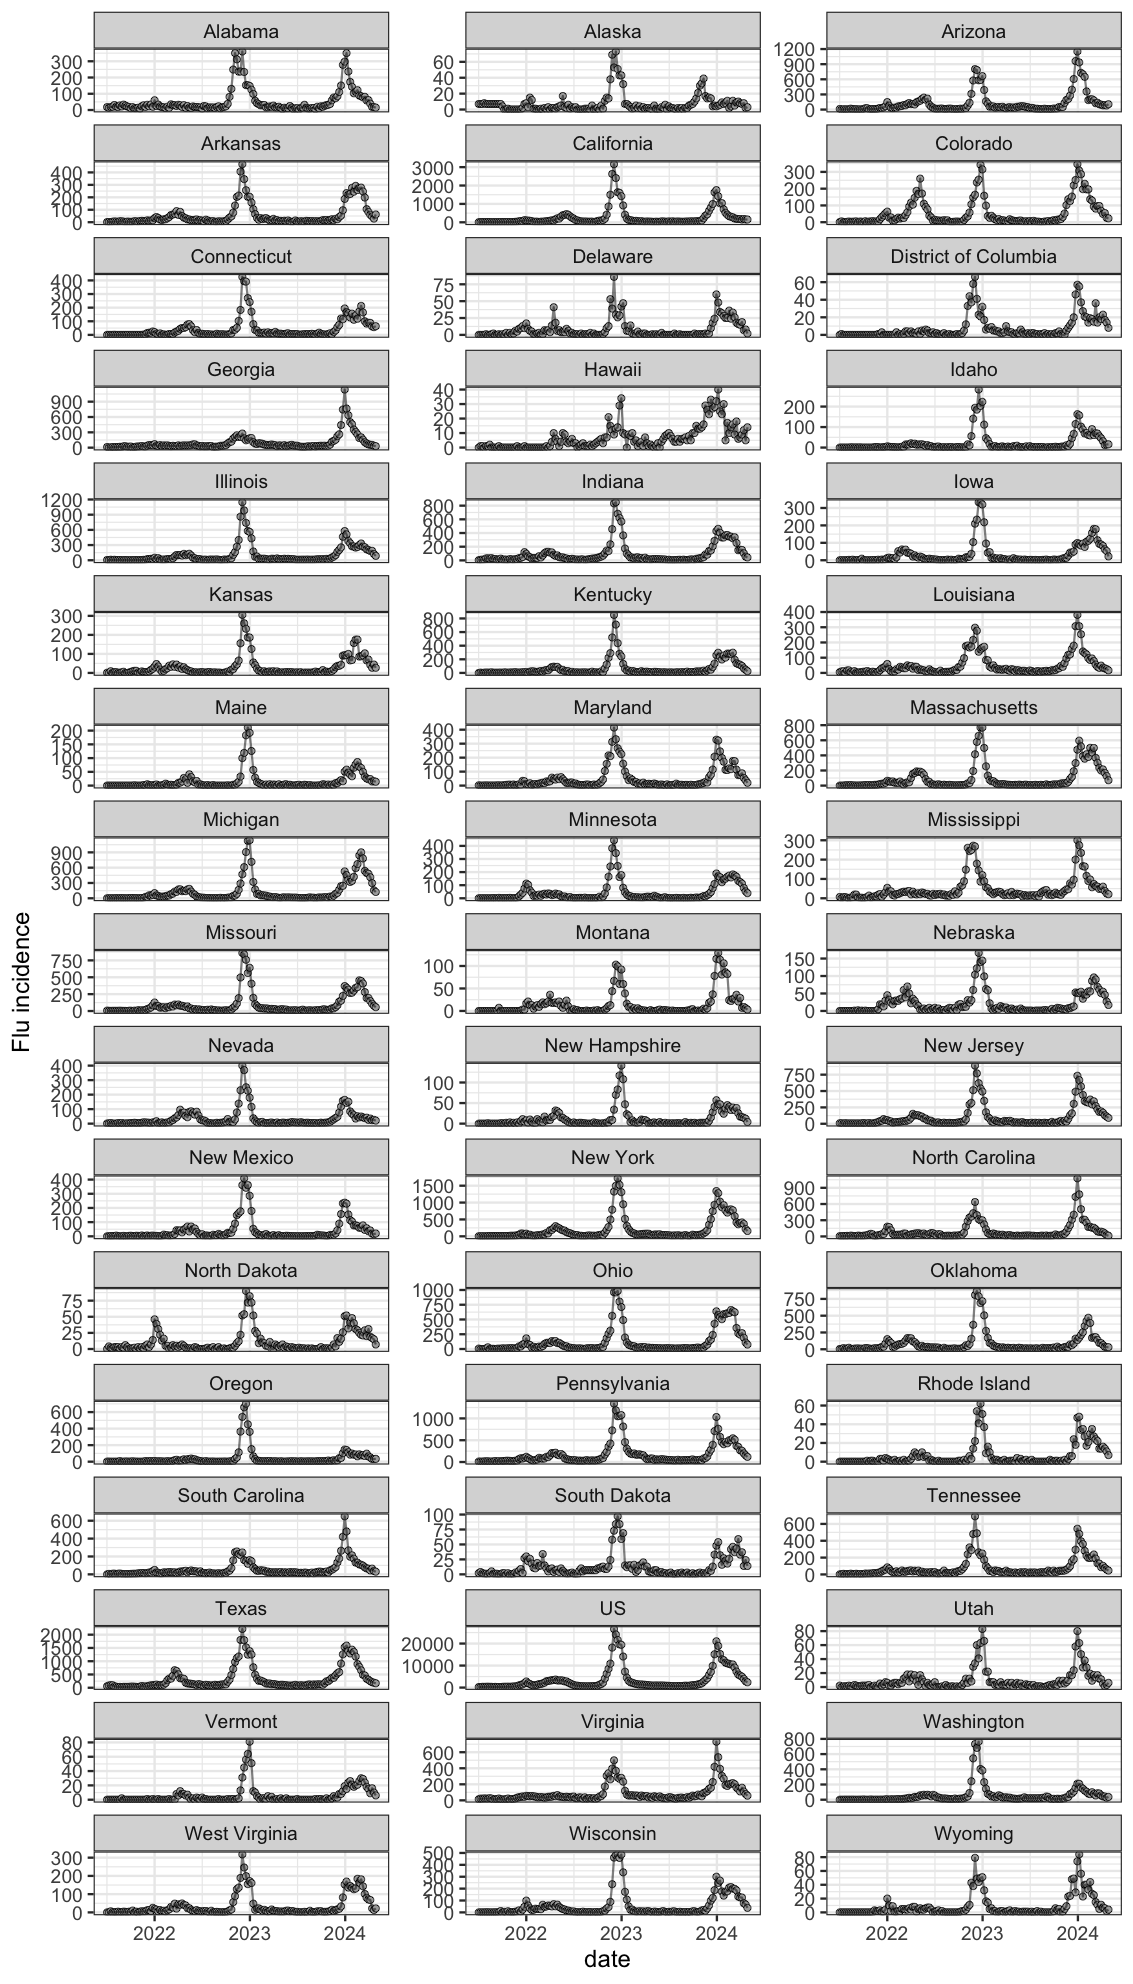

In [27]:
%%R -w 40 -h 70 -u cm

data$date <- ymd(data$date)

p.basic <- plot_basic_timeseries(data)
show(p.basic)

### Send to Python

In [28]:
%R data$date <- as.character(data$date)
%R -o data

### Create train and test split

In [29]:
num_train = 48

extrain, extest = make_data(data, num_train)
display(extest)

,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Georgia,...,Tennessee,Texas,US,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
date,,,,,,,,,,,,,,,,,,,,,
2022-06-04,19.0,2.0,216.0,19.0,445.0,76.0,20.0,9.0,5.0,65.0,...,25.0,121.0,2802.0,6.0,0.0,45.0,65.0,7.0,16.0,7.0
2022-06-11,19.0,6.0,97.0,22.0,409.0,39.0,36.0,6.0,2.0,42.0,...,20.0,106.0,2286.0,3.0,3.0,41.0,57.0,13.0,15.0,7.0
2022-06-18,17.0,1.0,57.0,13.0,315.0,28.0,14.0,2.0,2.0,36.0,...,29.0,137.0,1890.0,2.0,2.0,36.0,44.0,8.0,9.0,4.0
2022-06-25,15.0,3.0,38.0,16.0,249.0,9.0,6.0,3.0,3.0,25.0,...,22.0,123.0,1486.0,4.0,0.0,44.0,64.0,6.0,7.0,0.0
2022-07-02,8.0,2.0,16.0,12.0,199.0,14.0,8.0,1.0,1.0,34.0,...,28.0,96.0,1170.0,7.0,3.0,47.0,55.0,5.0,8.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-30,61.0,8.0,97.0,82.0,181.0,68.0,89.0,15.0,18.0,64.0,...,86.0,301.0,5445.0,11.0,15.0,111.0,56.0,71.0,126.0,11.0
2024-04-06,39.0,7.0,84.0,60.0,150.0,49.0,88.0,19.0,23.0,56.0,...,102.0,247.0,4951.0,5.0,9.0,157.0,43.0,68.0,125.0,7.0
2024-04-13,19.0,8.0,88.0,46.0,178.0,55.0,62.0,7.0,17.0,54.0,...,77.0,208.0,3954.0,1.0,16.0,110.0,42.0,22.0,77.0,6.0


## We'll start with predicting

### Construct a pipeline with transformation followed by predictions


In [30]:
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore::UserWarning"
    os.environ["PYTHONWARNINGS"] = "ignore::FutureWarning"
np.warnings = warnings

horizon = 4

sspipe = TransformerPipeline(steps = [TabularToSeriesAdaptor(PowerTransformer())])

arma_forecaster = AutoARIMA(sp = 1, suppress_warnings = True, error_action = "ignore", n_jobs = -1)

pipe = TransformedTargetForecaster(steps=[("preprocessor", sspipe),
                                          ("forecaster", arma_forecaster)])

all_horizons = pd.DataFrame()
all_models = []
for i in range(horizon): 
    country_predictions, models = generate_predictions_for_country(pipe, data, num_train, i + 1)
    all_horizons = pd.concat([all_horizons, country_predictions])
    all_models.append(models)

Alabama
TransformedTargetForecaster(steps=[('preprocessor',
                                    TransformerPipeline(steps=[TabularToSeriesAdaptor(transformer=PowerTransformer())])),
                                   ('forecaster',
                                    AutoARIMA(error_action='ignore', n_jobs=-1,
                                              suppress_warnings=True))])
Alaska
TransformedTargetForecaster(steps=[('preprocessor',
                                    TransformerPipeline(steps=[TabularToSeriesAdaptor(transformer=PowerTransformer())])),
                                   ('forecaster',
                                    AutoARIMA(error_action='ignore', n_jobs=-1,
                                              suppress_warnings=True))])
Arizona
TransformedTargetForecaster(steps=[('preprocessor',
                                    TransformerPipeline(steps=[TabularToSeriesAdaptor(transformer=PowerTransformer())])),
                                   ('forecaster',

In [31]:
all_horizons

,date,Model,Real,Persistence,horizon,dev
0,2022-06-04,15.425446,19.0,22.0,1,Alabama
1,2022-06-11,24.029854,19.0,19.0,1,Alabama
2,2022-06-18,22.807374,17.0,19.0,1,Alabama
3,2022-06-25,17.983637,15.0,17.0,1,Alabama
4,2022-07-02,17.529039,8.0,15.0,1,Alabama
...,...,...,...,...,...,...
96,2024-04-27,9.278371,4.0,11.0,4,Wyoming
97,2024-05-04,7.735924,NaN,7.0,4,Wyoming
98,2024-05-11,6.563134,NaN,6.0,4,Wyoming
99,2024-05-18,3.040335,NaN,2.0,4,Wyoming


### Push data over to R

In [32]:
%%capture
%R -i all_horizons

### Quick Error Check

In [33]:
%%R

all_horizons %>%
  drop_na() %>%
  filter(horizon == 1) %>%
  summarise(model = RMSE(Model, Real), 
            naive = RMSE(Persistence, Real))

     model    naive
1 323.6862 272.2569


In [34]:
%%R

all_horizons %>%
  drop_na() %>%
  filter(horizon == 1) %>%
  group_by(dev) %>%
  summarise(model = RMSE(Model, Real), 
            naive = RMSE(Persistence, Real))

# A tibble: 51 × 3
   dev                  model  naive
   <chr>                <dbl>  <dbl>
 1 Alabama               71.6  35.3 
 2 Alaska                10.4   7.09
 3 Arizona              104.   89.8 
 4 Arkansas              56.8  34.6 
 5 California           351.  224.  
 6 Colorado              36.8  30.6 
 7 Connecticut           36.2  36.2 
 8 Delaware              10.6  10.7 
 9 District of Columbia  10.5   7.28
10 Georgia               89.3  72.6 
# ℹ 41 more rows
# ℹ Use `print(n = ...)` to see more rows


In [37]:
%%R

all_horizons %>%
  drop_na() %>%
  group_by(horizon) %>%
  summarise(model = RMSE(Model, Real), 
            naive = RMSE(Persistence, Real),
            rRMSE = RMSE(Model, Real)/RMSE(Persistence, Real))

# A tibble: 4 × 4
  horizon model naive rRMSE
    <int> <dbl> <dbl> <dbl>
1       1  324.  272.  1.19
2       2  691.  489.  1.41
3       3 1118.  659.  1.70
4       4 1562.  804.  1.94


In [35]:
%%R

tmp <- read_csv('../../imputed_and_stitched_hosp.csv') %>%
  arrange(date)

sarima.r <- all_horizons %>%
  mutate(value = Model,
         date_predicted = date,
         location_name = dev,
         target_value = Real) %>%
  select(date_predicted, value, target_value, location_name, horizon) %>%
  mutate(date_created = Sys.Date(),
         aggregation = 'weekly', 
         model = 'sarima', 
         target = 'cases') %>%
  relocate(any_of(c("date_created", "date_predicted", 
                    "aggregation", 'location_name',
                    'model', 'target', 'horizon', 'value', 'target_value')))

write_csv(sarima.r, file = 'flu_sarima_predictions_paper_completion_no_imputed.csv')

Rows: 31779 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): location_name
dbl  (5): ili, pred_hosp, true_hosp, population, total_hosp
date (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
